# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.collocations import BigramAssocMeasures
from nltk.collocations import BigramCollocationFinder
from nltk.tokenize import word_tokenize
import math
import seaborn as sns
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

# Defining Working Subset - Randomly Sampling 100k Transcripts

In [2]:
subset = 100000

In [3]:
data = pd.read_csv('data/CTQ1_anonymized.csv', index_col = [0])
data = data.sample(n=subset)
data.head()

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (1,2,3,4,5,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,FISC_QTR_VAL,FISC_WEEK_VAL,Group_name,Region_name,Sub_Region_name,Case_number,Chat_Create_date,Chat_Txnsrpt_body
0,2021-Q1,2021-W01,CBS-Commercial,AMERICAS,United States,49861514.0,2/4/2020 20:58,"<p align=center>Chat NAME: {{NAME}}, {{NAME}} ..."
1,2021-Q1,2021-W01,CBS-Commercial,AMERICAS,United States,49771157.0,2/3/2020 21:24,"<p align=center>Chat NAME: {{NAME}}, {{NAME}} ..."
2,2021-Q1,2021-W01,CBS-Commercial,AMERICAS,United States,49769079.0,2/3/2020 20:50,"<p align=center>Chat NAME: {{NAME}}, {{NAME}} ..."
3,2021-Q1,2021-W01,CBS-Commercial,AMERICAS,United States,49687660.0,2/3/2020 1:27,"<p align=center>Chat NAME: {{NAME}}, {{NAME}} ..."
4,2021-Q1,2021-W01,CBS-Commercial,AMERICAS,United States,50007941.0,2/6/2020 13:59,"<p align=center>Chat NAME: {{NAME}}, {{NAME}} ..."


# TF-IDF Model 1 - Separating Agent Transcripts from Customer Transcripts

## Delineating agent transcripts from customer transcripts

In [4]:
def chat_parse(body):
    bodystr = str(body)
    chat = bodystr.replace("{{NAME}}", "").replace("NAME", "")
    splits = re.split('\( [0-9]*m* [0-9]+s \)', chat)
    split_first = splits[0]
    early_chats = re.split('\( [0-9]+s \)', split_first)
    early_chats.extend(splits[1:])
    return early_chats

In [5]:
# cleaned.iloc['Parsed'] = chat_parse(data.iloc[i]['Chat_Txnsrpt_body'])
cleaned_chats = data['Chat_Txnsrpt_body'].apply(lambda x : chat_parse(x))

In [6]:
cleaned_chats[0]

['<p align=center>Chat : ,  04, 2020, 12:59:24 (-0800)</p><p align=center>Chat : NA.TS.CLI.CHAT.EN.CORE.COM.OPTLAT</p><p align=center>Agent  V</p>',
 '  : Thank you for contacting   . My Name is . Please give me a moment while I review your case details. ',
 '  : Hello , How are you doing today? ',
 ' : I&#39;m well thank you. ',
 '  : Glad to hear :) ',
 '  : I see that you are experiencing issue with your system as its  is failed, right? ',
 ' : correct. ',
 '  : I apologize for any inconvenience this may have caused you. ',
 '  : As we are connected, I am going to take care of this issue and will make every effort that is possible from my end to fix this issue to your satisfaction ',
 '  : Can you confirm that the system you need support with is SERVICETAGE 7480, with   : SERVICETAG? ',
 ' : Thank you. Yes that information and service tag is correct. ',
 '  : Thank you for your confirmation. Your system still has an active   valid until XX/XX/XXXX. ',
 '  : If we get disconnected fr

In [7]:
data['Agent_chat'] = cleaned_chats.apply(lambda x: x[1::2])
data['Customer_chat'] = cleaned_chats.apply(lambda x: x[2::2])

In [8]:
data['Agent_chat'][0]

['  : Thank you for contacting   . My Name is . Please give me a moment while I review your case details. ',
 ' : I&#39;m well thank you. ',
 '  : I see that you are experiencing issue with your system as its  is failed, right? ',
 '  : I apologize for any inconvenience this may have caused you. ',
 '  : Can you confirm that the system you need support with is SERVICETAGE 7480, with   : SERVICETAG? ',
 '  : Thank you for your confirmation. Your system still has an active   valid until XX/XX/XXXX. ',
 ' : yes that is my correct contact info. ',
 ' : 8am-5pm  ',
 '  : Please tell me if you&#39;ve performed any additional steps on your own apart from EPSA test. So that we may skip those and save some time &amp; trouble. ',
 '  : Let me quickly see what steps we can perform. ',
 ' : my user reported fan error message']

In [9]:
data['Customer_chat'][0]

['  : Hello , How are you doing today? ',
 '  : Glad to hear :) ',
 ' : correct. ',
 '  : As we are connected, I am going to take care of this issue and will make every effort that is possible from my end to fix this issue to your satisfaction ',
 ' : Thank you. Yes that information and service tag is correct. ',
 '  : If we get disconnected from this chat, can I reach you at {{PHONE}} or email you at {{EMAIL}}? ',
 '  : Could you confirm the best time to reach you along with your time zone? ',
 '  : Thanks for all the info.We should be done in about 14-15 minutes. ',
 ' : I have not do you need the bios revision? ',
 ' : bios version is 1.16.1 ']

## Creating dictionary of keywords

### Unigrams

In [7]:
# nltk.download('stopwords')
# nltk.download('punkt')
ignored_words = list(stopwords.words('english'))
ignored_words.extend('''thank please name phone 39 yes moment email contacting give get need may let reach
                        confirm number chat disconnected hello today could still good know minutes xx hi okay
                        send apologize best work inconvenience thanks already well along concern check
                        follow would use also ok one sure like contact xxxx see ask asking questions steps great
                        fine amp together right back ways done chatting receive go us else case correct time
                        service help allow day understand confirmation anything support assist information tag
                        servicetag customer survey feedback agent servicetage feel free days business mins next
                        cte resolution servicetagized issue issues respond chats 7490 wait i\\x1all i\\x1am
                        quick move user details review prosupport address quot'''.split())

In [8]:
count_vec = CountVectorizer(
    ngram_range = (1,1)
    ,stop_words = ignored_words
)
text_set     = [str(chat).lower() for chat in data['Agent_chat']]
tf_result    = count_vec.fit_transform(text_set)
tf_result_df = pd.DataFrame(tf_result.toarray(),columns=count_vec.get_feature_names())
the_sum_s = tf_result_df.sum(axis=0)
the_sum_df = pd.DataFrame({'keyword':the_sum_s.index,'tf_sum':the_sum_s.values})

#include only if it appears more than twice
the_sum_df = the_sum_df[the_sum_df['tf_sum']>2].sort_values(by=['tf_sum'],ascending=False)

KeyError: 'Agent_chat'

In [12]:
#include only if string longer than two characters
my_word_df = the_sum_df.iloc[:]
my_word_df = the_sum_df[my_word_df['keyword'].str.len()>2]

In [81]:
my_word_df[:10]

,keyword,tf_sum
44505,system,72608
11766,battery,18923
34703,power,15003
12263,bios,13634
15296,computer,13254
27826,laptop,13224
18457,dispatch,13089
47403,update,11678
13948,center,11600
48557,warranty,11379


### Bigrams

In [14]:
text_set_words  = [word_tokenize(str(chat).lower()) for chat in data['Agent_chat']]
bigram_measures = BigramAssocMeasures()
finder = BigramCollocationFinder.from_documents(text_set_words)
finder.apply_freq_filter(3)
finder.apply_word_filter(lambda w: len(w) < 3 or len(w) > 15 or w.lower() in ignored_words)
phrase_result = finder.nbest(bigram_measures.raw_freq, 200)
colloc_strings = [w1+' '+w2 for w1,w2 in phrase_result]

In [82]:
phrase_result[:10]

[('active', 'valid'),
 ('file', 'transfer'),
 ('hard', 'drive'),
 ('power', 'button'),
 ('transfer', 'succeeded.'),
 ('physical', 'damage'),
 ('docking', 'station'),
 ('tech', 'expert'),
 ('operating', 'system'),
 ('accidental', 'damage')]

### Creating combined vocabulary of unigrams and bigrams

In [16]:
my_vocabulary = []
my_vocabulary.extend(my_word_df['keyword'].tolist()) 
my_vocabulary.extend(colloc_strings)

In [17]:
vec = TfidfVectorizer(analyzer     ='word', ngram_range =(1, 2) ,vocabulary=my_vocabulary)
text_set = [str(chat).lower() for chat in data['Customer_chat']]
tf_idf = vec.fit_transform(text_set)
result_tfidf = pd.DataFrame(tf_idf.toarray(), columns=vec.get_feature_names())

In [18]:
result_tfidf

,system,battery,power,bios,computer,laptop,dispatch,update,center,warranty,...,slow performance,changes made,data loss,dell command,got everything,even though,opti 3070,software changes,boot menu,download option
0,0.000000,0.000000,0.0,0.297022,0.0,0.000000,0.000000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.084890,0.147757,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.113225,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.045040,0.000000,0.0,0.079348,0.0,0.000000,0.000000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.180197,0.0,0.176219,0.000000,0.17875,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99996,0.154081,0.000000,0.0,0.000000,0.0,0.000000,0.129788,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99997,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99998,0.172788,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Check whether assumption is good

In [19]:
ignored_words_check = list(stopwords.words('english'))
ignored_words_check.extend('''thank email please chat servicetag phone number service tag best ways get disconnected anything else may receive'''.split())

In [20]:
count_vec_check = CountVectorizer(
    ngram_range = (1,1)
    ,stop_words = ignored_words_check
)
text_set_check     = [str(chat).lower() for chat in data['Customer_chat']]
tf_result_check    = count_vec_check.fit_transform(text_set_check)
tf_result_df_check = pd.DataFrame(tf_result_check.toarray(),columns=count_vec_check.get_feature_names())
the_sum_s_check = tf_result_df_check.sum(axis=0)
the_sum_df_check = pd.DataFrame({'keyword':the_sum_s_check.index,'tf_sum':the_sum_s_check.values})

#include only if it appears more than twice
the_sum_df_check = the_sum_df_check[the_sum_df_check['tf_sum']>2].sort_values(by=['tf_sum'],ascending=False)

In [21]:
#include only if string longer than two characters
my_word_df_check = the_sum_df_check.iloc[:]
my_word_df_check = the_sum_df_check[my_word_df_check['keyword'].str.len()>2]

In [22]:
my_word_df_check[:20]

,keyword,tf_sum
43515,system,72934
25817,issue,56538
49284,yes,54773
30295,need,43505
44848,today,38769
15776,correct,36186
38279,see,35363
35382,reach,31150
22680,good,30572
48483,would,27562


In [23]:
text_set_words_check  = [word_tokenize(str(chat).lower()) for chat in data['Customer_chat']]
bigram_measures_check = BigramAssocMeasures()
finder_check = BigramCollocationFinder.from_documents(text_set_words_check)
finder_check.apply_freq_filter(3)
finder_check.apply_word_filter(lambda w: len(w) < 15 or len(w) > 15 or w.lower() in ignored_words_check)
phrase_result_check = finder_check.nbest(bigram_measures_check.raw_freq, 200)
colloc_strings_check = [w1+' '+w2 for w1,w2 in phrase_result_check]
colloc_strings_check

[]

## Scoring

In [24]:
result_tfidf['Score'] = result_tfidf.sum(axis = 1, numeric_only=True)

(array([1.9990e+03, 3.6660e+03, 8.3240e+03, 1.8065e+04, 3.0962e+04,
        2.5970e+04, 8.8600e+03, 1.8550e+03, 2.8200e+02, 1.7000e+01]),
 array([0.        , 0.94412822, 1.88825644, 2.83238466, 3.77651288,
        4.7206411 , 5.66476932, 6.60889754, 7.55302576, 8.49715398,
        9.4412822 ]),
 <BarContainer object of 10 artists>)

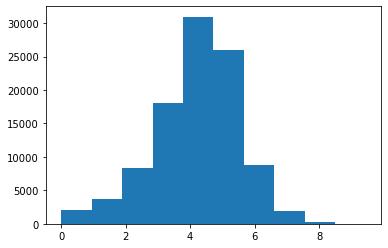

In [80]:
plt.hist(result_tfidf['Score'], bins=10)

In [25]:
result_tfidf

,system,battery,power,bios,computer,laptop,dispatch,update,center,warranty,...,changes made,data loss,dell command,got everything,even though,opti 3070,software changes,boot menu,download option,Score
0,0.000000,0.000000,0.0,0.297022,0.0,0.000000,0.000000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.463889
1,0.084890,0.147757,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.623683
2,0.113225,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.965369
3,0.045040,0.000000,0.0,0.079348,0.0,0.000000,0.000000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.208526
4,0.000000,0.000000,0.0,0.180197,0.0,0.176219,0.000000,0.17875,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.213599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.007648
99996,0.154081,0.000000,0.0,0.000000,0.0,0.000000,0.129788,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.869264
99997,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.781255
99998,0.172788,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.294540


In [26]:
score_mean = result_tfidf["Score"].mean()
score_mean

4.204606354972878

In [27]:
score_sd = result_tfidf["Score"].std()
score_sd

1.342381377102074

In [28]:
result_tfidf["Mod_Score"] = ((result_tfidf["Score"] - score_mean)/score_sd)*2 + 5

In [29]:
result_tfidf["Mod_Score"].min()

-1.264399114430148

In [35]:
scores = result_tfidf["Mod_Score"]

In [36]:
scores[scores < 1] = 1
scores[scores > 10] = 10
scores.mean()

5.026165213822624

In [39]:
manual = pd.read_csv("Manual.csv")

In [40]:
manual.head()

,FISC_QTR_VAL,FISC_WEEK_VAL,Group_name,Region_name,Sub_Region_name,Case_number,Chat_Create_date,Chat_Txnsrpt_body,manual_score
0,2021-Q1,2021-W01,CBS-Commercial,AMERICAS,United States,49861514,2/4/2020 20:58,"<p align=center>Chat NAME: {{NAME}}, {{NAME}} ...",4
1,2021-Q1,2021-W01,CBS-Commercial,AMERICAS,United States,49771157,2/3/2020 21:24,"<p align=center>Chat NAME: {{NAME}}, {{NAME}} ...",8
2,2021-Q1,2021-W01,CBS-Commercial,AMERICAS,United States,49769079,2/3/2020 20:50,"<p align=center>Chat NAME: {{NAME}}, {{NAME}} ...",3
3,2021-Q1,2021-W01,CBS-Commercial,AMERICAS,United States,49687660,2/3/2020 1:27,"<p align=center>Chat NAME: {{NAME}}, {{NAME}} ...",9
4,2021-Q1,2021-W01,CBS-Commercial,AMERICAS,United States,50007941,2/6/2020 13:59,"<p align=center>Chat NAME: {{NAME}}, {{NAME}} ...",10


In [72]:
manual["predicted_score"] = scores[:301]

In [73]:
manual[-5:]

,FISC_QTR_VAL,FISC_WEEK_VAL,Group_name,Region_name,Sub_Region_name,Case_number,Chat_Create_date,Chat_Txnsrpt_body,manual_score,predicted_score
296,2021-Q1,2021-W01,Client Basic Support Consumer,AMERICAS,United States,49683308,2/2/2020 18:36,"<p align=center>Chat NAME: {{NAME}}, {{NAME}} ...",1,1.000000
297,2021-Q1,2021-W01,Client Basic Support Consumer,AMERICAS,United States,49667676,2/1/2020 22:19,"<p align=center>Chat NAME: {{NAME}}, {{NAME}} ...",2,1.641756
298,2021-Q1,2021-W01,CBS-Commercial,AMERICAS,United States,49850975,2/4/2020 18:48,"<p align=center>Chat NAME: {{NAME}}, {{NAME}} ...",3,3.845496
299,2021-Q1,2021-W01,Client Basic Support Consumer,AMERICAS,United States,49872572,2/5/2020 0:47,"<p align=center>{{NAME}} NAME: {{NAME}}, {{NAM...",4,6.263108
300,2021-Q1,2021-W01,CBS-Commercial,AMERICAS,United States,49952718,2/5/2020 21:22,"<p align=center>Chat NAME: {{NAME}}, {{NAME}} ...",4,3.574758


In [74]:
sse = sum((manual["manual_score"] - manual["predicted_score"])**2)
rmse = math.sqrt(sse/301)
rmse

2.0729539916379096

In [77]:
manual["manual_is_proficient"] = manual["manual_score"] > 5
manual["predicted_is_proficient"] = manual["predicted_score"] > 5
manual["correctly_predicted"] = np.where((manual["manual_is_proficient"] == manual["predicted_is_proficient"]), True, False)
manual["correctly_predicted"].sum()/301

0.6146179401993356

# TF-IDF Model 2: Using Entire Conversations

In [9]:
data['Full_chat'] = cleaned_chats.apply(lambda x: x[1::])

In [10]:
data['Full_chat']

0        [  : Thank you for contacting   . My Name is ....
1        [  : Thank you for contacting   . My Name is ....
2        [  : Thank you for contacting   . My Name is ....
3        [  : Thank you for contacting   . My Name is ....
4        [   : Thank you for contacting     . My name i...
                               ...                        
99995    [ : Hey  ,   : Good afternoon ! How can I assi...
99996    [  : Thank you for contacting   . My Name is ....
99997    [  : Good afternoon , how can I help you? ,  :...
99998    [  : Thank you for contacting CTE. Please allo...
99999    [  : Hey  how&#39;s it going? ,  : Good   its ...
Name: Full_chat, Length: 100000, dtype: object

## Creating Dictionary of Keywords

In [11]:
count_vec_full = CountVectorizer(
    ngram_range = (1,1)
    ,stop_words = ignored_words
)
text_set_full     = [str(chat).lower() for chat in data['Full_chat']]
tf_result_full    = count_vec_full.fit_transform(text_set_full)
tf_result_df_full = pd.DataFrame(tf_result_full.toarray(),columns=count_vec_full.get_feature_names())
the_sum_s_full = tf_result_df_full.sum(axis=0)
the_sum_df_full = pd.DataFrame({'keyword':the_sum_s_full.index,'tf_sum':the_sum_s_full.values})

#include only if it appears more than twice
the_sum_df_full = the_sum_df_full[the_sum_df_full['tf_sum']>2].sort_values(by=['tf_sum'],ascending=False)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['x1all', 'x1am'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [13]:
#include only if string longer than two characters
my_word_df_full = the_sum_df_full.iloc[:]
my_word_df_full = the_sum_df_full[my_word_df_full['keyword'].str.len()>2]

In [14]:
my_word_df_full[:10]

,keyword,tf_sum
64598,system,145542
17541,battery,37960
50658,power,30372
18253,bios,27409
22641,computer,27284
40730,laptop,26787
27196,dispatch,26295
68838,update,23792
70473,warranty,23294
20685,center,22878


In [15]:
text_set_words_full  = [word_tokenize(str(chat).lower()) for chat in data['Full_chat']]
bigram_measures_full = BigramAssocMeasures()
finder_full = BigramCollocationFinder.from_documents(text_set_words_full)
finder_full.apply_freq_filter(15)
finder_full.apply_word_filter(lambda w: len(w) < 3 or len(w) > 15 or w.lower() in ignored_words)
phrase_result_full = finder_full.nbest(bigram_measures_full.raw_freq, 200)
colloc_strings_full = [w1+' '+w2 for w1,w2 in phrase_result_full]

In [16]:
phrase_result_full[:10]

[('file', 'transfer'),
 ('active', 'valid'),
 ('hard', 'drive'),
 ('power', 'button'),
 ('transfer', 'succeeded.'),
 ('physical', 'damage'),
 ('docking', 'station'),
 ('operating', 'system'),
 ('accidental', 'damage'),
 ('error', 'code')]

In [17]:
my_vocabulary_full = []
my_vocabulary_full.extend(my_word_df_full['keyword'].tolist()) 
my_vocabulary_full.extend(colloc_strings_full)

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec_full = TfidfVectorizer(analyzer     ='word', ngram_range =(1, 2) ,vocabulary=my_vocabulary_full)
text_set_full = [str(chat).lower() for chat in data['Full_chat']]
tf_idf_full = vec_full.fit_transform(text_set_full)
result_tfidf_full = pd.DataFrame(tf_idf_full.toarray(), columns=vec_full.get_feature_names())

In [19]:
result_tfidf_full

,system,battery,power,bios,computer,laptop,dispatch,update,warranty,center,...,got everything,left side,dispatch set,battery warranty,hardware warranty,\x1as basic,start download,lati 5500,recovery tool,last thing
0,0.150415,0.000000,0.000000,0.187544,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.228895,0.111796,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.057822,0.112966,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.069837,0.000000,0.000000,0.065307,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.150205,0.0
4,0.000000,0.000000,0.000000,0.147598,0.0,0.141595,0.067423,0.147826,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.055222,0.000000,0.035406,0.137707,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
99996,0.165084,0.000000,0.000000,0.000000,0.0,0.000000,0.094025,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
99997,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.103471,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
99998,0.141607,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.066313,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [20]:
result_tfidf_full['Score_full'] = result_tfidf_full.sum(axis = 1, numeric_only=True)

(array([9.0000e+02, 1.1890e+03, 3.5180e+03, 7.4790e+03, 1.2870e+04,
        2.7888e+04, 3.2841e+04, 1.2093e+04, 1.1950e+03, 2.7000e+01]),
 array([0.        , 0.995507  , 1.991014  , 2.98652101, 3.98202801,
        4.97753501, 5.97304201, 6.96854902, 7.96405602, 8.95956302,
        9.95507002]),
 <BarContainer object of 10 artists>)

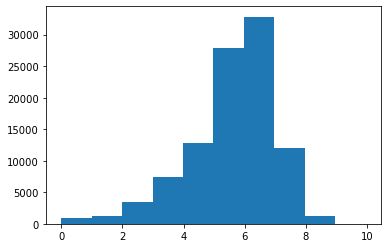

In [35]:
import matplotlib.pyplot as plt
plt.hist(result_tfidf_full['Score_full'], bins=10)

In [36]:
score_mean_full = result_tfidf_full["Score_full"].mean()
score_sd_full = result_tfidf_full["Score_full"].std()
result_tfidf_full["Mod_Score_full"] = ((result_tfidf_full["Score_full"] - score_mean_full)/score_sd_full)*2 + 5

In [37]:
scores_full = result_tfidf_full["Mod_Score_full"]

In [38]:
scores_full[scores_full < 1] = 1
scores_full[scores_full > 10] = 10
scores_full.mean()

5.0655981817584355

(array([21., 27., 39., 51., 57., 46., 30., 16., 12.,  2.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

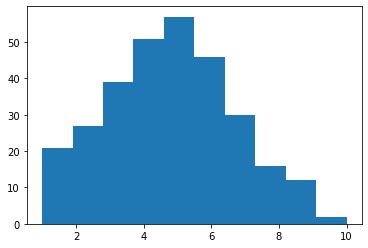

In [71]:
plt.hist(manual['manual_score'], bins=10)

In [41]:
manual["predicted_score_full"] = scores_full[:301]

In [42]:
sse_full = sum((manual["manual_score"] - manual["predicted_score_full"])**2)
rmse_full = math.sqrt(sse_full/301)
rmse_full

1.953814355159145

In [43]:
manual["manual_is_proficient"] = manual["manual_score"] > 5
manual["predicted_full_is_proficient"] = manual["predicted_score_full"] > 5


array([[125,  70],
       [ 34,  72]])

In [45]:
cf_matrix_full = confusion_matrix(manual["manual_is_proficient"], manual["predicted_full_is_proficient"])

<AxesSubplot:>

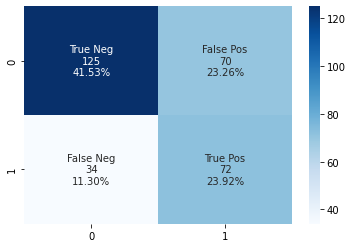

In [49]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_full.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_full.flatten()/np.sum(cf_matrix_full)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix_full, annot=labels, fmt='', cmap='Blues')

In [51]:
manual["manual_score"].corr(manual["predicted_score_full"])

0.44514322061189054

In [52]:
manual["predicted_rounded_full"] = round(manual["predicted_score_full"])

In [53]:
manual["manual_score"].corr(manual["predicted_rounded_full"])

0.43657324085610755

In [57]:
manual[manual['manual_score'] == manual['predicted_rounded_full']].count()

FISC_QTR_VAL                    60
FISC_WEEK_VAL                   60
Group_name                      60
Region_name                     60
Sub_Region_name                 60
Case_number                     60
Chat_Create_date                60
Chat_Txnsrpt_body               60
manual_score                    60
predicted_score_full            60
manual_is_proficient            60
predicted_full_is_proficient    60
predicted_rounded_full          60
dtype: int64

### Alternate Approach - Dividing scores into buckets of 'Low', 'Medium' and 'High' to compare performance

In [59]:
manual['predicted_score_class'] = pd.qcut(x = manual['predicted_rounded_full'], q = [0, 0.25, 0.75, 1],
                                         labels = ['Low', 'Medium', 'High'])

In [61]:
manual['manual_score_class'] = pd.qcut(x = manual['manual_score'], q = [0, 0.25, 0.75, 1],
                                         labels = ['Low', 'Medium', 'High'])

In [62]:
manual.head()

,FISC_QTR_VAL,FISC_WEEK_VAL,Group_name,Region_name,Sub_Region_name,Case_number,Chat_Create_date,Chat_Txnsrpt_body,manual_score,predicted_score_full,manual_is_proficient,predicted_full_is_proficient,predicted_rounded_full,predicted_score_class,manual_score_class
0,2021-Q1,2021-W01,CBS-Commercial,AMERICAS,United States,49861514,2/4/2020 20:58,"<p align=center>Chat NAME: {{NAME}}, {{NAME}} ...",4,6.618794,False,True,7.0,High,Medium
1,2021-Q1,2021-W01,CBS-Commercial,AMERICAS,United States,49771157,2/3/2020 21:24,"<p align=center>Chat NAME: {{NAME}}, {{NAME}} ...",8,4.985877,True,False,5.0,Medium,High
2,2021-Q1,2021-W01,CBS-Commercial,AMERICAS,United States,49769079,2/3/2020 20:50,"<p align=center>Chat NAME: {{NAME}}, {{NAME}} ...",3,4.507493,False,False,5.0,Medium,Low
3,2021-Q1,2021-W01,CBS-Commercial,AMERICAS,United States,49687660,2/3/2020 1:27,"<p align=center>Chat NAME: {{NAME}}, {{NAME}} ...",9,5.283864,True,True,5.0,Medium,High
4,2021-Q1,2021-W01,CBS-Commercial,AMERICAS,United States,50007941,2/6/2020 13:59,"<p align=center>Chat NAME: {{NAME}}, {{NAME}} ...",10,6.242252,True,True,6.0,Medium,High


## Model Accuracy

In [69]:
acc = (manual[manual['predicted_score_class'] == manual['manual_score_class']]['FISC_QTR_VAL'].count())*100/len(manual)
acc

48.83720930232558